In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
#from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model
import json

import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip

import psycopg2

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")
EMBEDDINGS_FOLDER = PARENT + os.getenv("EMBEDDINGS_FOLDER")
MODELS_FOLDER = PARENT + os.getenv("MODELS_FOLDER")

DB_INPUT_ARTPIECES = PARENT + os.getenv("DB_INPUT_ARTPIECES")
DB_INPUT_ARTISTS = PARENT + os.getenv("DB_INPUT_ARTISTS")
DB_INPUT_SUBJECTMATTER = PARENT + os.getenv("DB_INPUT_SUBJECTMATTER")

def get_db_config():
    return {
        "host": os.getenv("DB_HOST"),
        "port": os.getenv("DB_PORT"),
        "name": os.getenv("DB_NAME"),
        "user": os.getenv("DB_USER"),
        "password": os.getenv("DB_PASSWORD"),
    }

##

def fixPath(path):
    return path.replace(".././", "../")

In [4]:
# Query the DB for all the recordIDs of the table Artwork
def get_image_data_from_db(db_config):
    conn = None
    try:
        conn = psycopg2.connect(
            host=db_config["host"],
            port=db_config["port"],
            database=db_config["name"],
            user=db_config["user"],
            password=db_config["password"]
        )
        cur = conn.cursor()
        cur.execute(f"SELECT recordID, imageLowResFilename FROM Artwork")
        data = cur.fetchall()
        cur.close()
        return data
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

DATA = get_image_data_from_db(get_db_config())
DATA[:5]

[(64, '/art-foto/old/internet/Bouts-8181dig-L.jpg'),
 (77, '/art-foto/mod/Internet/deSmet-11120dig-L.jpg'),
 (78, '/art-foto/mod/Internet/Khnopff-3980dig-L.jpg'),
 (79, '/art-foto/mod/Internet/Khnopff-6366dig-L.jpg'),
 (80, '/art-foto/mod/Internet/Khnopff-6768dig-L.jpg')]

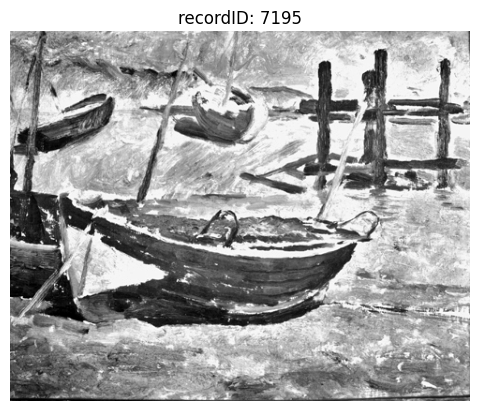

In [5]:
# Show a random image
def getImagePath(image_path):
    return fixPath(os.path.join(IMAGES_FOLDER, image_path[1:]))

recordID, image_path = random.choice(DATA)
image = Image.open(getImagePath(image_path))
plt.imshow(image, cmap="gray")
plt.title(f"recordID: {recordID}")
plt.axis("off")
plt.show()

In [6]:
model_name_db = "march_finetuned"
path_embeddings = PARENT + os.getenv(f"{model_name_db}_path_embeddings")
path_index_to_recordID = PARENT + os.getenv(f"{model_name_db}_path_index_to_recordID")
path_keywords_embeddings = PARENT + os.getenv(f"{model_name_db}_path_keywords_embeddings")
path_keywords_term_to_index = PARENT + os.getenv(f"{model_name_db}_path_keywords_term_to_index")

In [7]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
tokenizer = transformers.AutoTokenizer.from_pretrained("openai/clip-vit-large-patch14")
# Load the weights of the model
weights_path = PARENT + os.getenv(f"{model_name_db}_weights_path")
# Load the weights of the model
model.load_state_dict(torch.load(weights_path))

C:\Users\victo\AppData\Local\Temp\ipykernel_18988\2166279357.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [8]:
class ComputeEmbeddingsDataset(Dataset):
    def __init__(self, data, getImagePath):
        self.data = data
        self.getImagePath = getImagePath

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        _, image_path = self.data[idx]
        path = self.getImagePath(image_path)
        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)

        return image
    
def customBatchBuilder(images):
    inputs = processor(text=[""] * len(images), images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

dataset = ComputeEmbeddingsDataset(DATA, getImagePath)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=customBatchBuilder)
print(len(dataset), len(dataloader))

5301 5301


In [9]:
path_embeddings

'./../.././private_data/embeddings/march_finetuned/march_finetuned_embeddings.npy'

In [14]:
# Create the folders if they don't exist
os.makedirs(PARENT + os.getenv("EMBEDDINGS_FOLDER") + model_name_db, exist_ok=True)

In [10]:
def compute_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)
            pixel_values = sample['pixel_values'].to(device)

            # Compute image embeddings
            image_features = model.get_image_features(pixel_values=pixel_values)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            image_features = image_features.flatten(1)

            embeddings.append(image_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

images_embeddings = compute_embeddings(dataloader, model, device)
# Save the embeddings
np.save(path_embeddings, images_embeddings)
images_embeddings.shape

100%|██████████| 5301/5301 [02:49<00:00, 31.36it/s]


FileNotFoundError: [Errno 2] No such file or directory: './../.././private_data/embeddings/march_finetuned/march_finetuned_embeddings.npy'

In [16]:
index_to_recordID = {}
for i, (recordID, _) in enumerate(DATA):
    index_to_recordID[i] = recordID

with open(path_index_to_recordID, "w") as f:
    json.dump(index_to_recordID, f)

In [17]:
class ComputeKeywordsEmbeddingsDataset(Dataset):
    def __init__(self, keys, keywords):
        self.keys = keys
        self.keywords = keywords

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        key = self.keys[idx]
        synonyms = self.keywords[key]
        # Prompt-engineering
        prompt = ", ".join ([key] + synonyms)
        
        return prompt

keywords = {
    "fleur": ["fleur", "floraison", "élément végétal", "partie de plante"],
    "arbre": ["arbre", "végétal ligneux", "plante arboricole", "structure végétale"],
    "montagne": ["montagne", "élévation", "relief", "formation géologique"],
    "rivière": ["rivière", "cours d'eau", "flux aquatique", "voie fluviale"],
    "océan": ["océan", "étendue d'eau", "masse aquatique", "domaine marin"],
    "ciel": ["ciel", "atmosphère", "espace aérien", "voûte céleste"],
    "étoile": ["étoile", "astre", "corps céleste", "point lumineux"],
    "lune": ["lune", "satellite naturel", "corps lunaire", "astre nocturne"],
    "soleil": ["soleil", "astre solaire", "source lumineuse", "corps stellaire"],
    "nuage": ["nuage", "formation nuageuse", "amas de vapeur", "élément atmosphérique"],
    "animal": ["animal", "être vivant", "organisme", "créature"],
    "oiseau": ["oiseau", "volatile", "espèce aviaire", "animal à plumes"],
    "poisson": ["poisson", "espèce aquatique", "animal marin", "organisme aquatique"],
    "insecte": ["insecte", "arthropode", "invertébré", "animal segmenté"],
    "reptile": ["reptile", "animal à sang froid", "vertébré terrestre", "espèce reptilienne"],
    "fruit": ["fruit", "produit végétal", "partie comestible", "élément de plante"],
    "légume": ["légume", "produit potager", "aliment végétal", "partie de plante comestible"],
    "nourriture": ["nourriture", "aliment", "substance comestible", "produit alimentaire"],
    "boisson": ["boisson", "liquide", "breuvage", "substance à boire"],
    "pain": ["pain", "produit de boulangerie", "aliment à base de farine", "produit céréalier"],
    "maison": ["maison", "habitation", "structure résidentielle", "bâtiment d'habitation"],
    "bâtiment": ["bâtiment", "construction", "structure", "édifice"],
    "église": ["église", "lieu de culte", "édifice religieux", "structure sacrée"],
    "pont": ["pont", "structure de passage", "ouvrage d'art", "liaison entre deux points"],
    "rue": ["rue", "voie de circulation", "artère urbaine", "chemin urbain"],
    "voiture": ["voiture", "véhicule automobile", "moyen de transport", "véhicule terrestre"],
    "avion": ["avion", "aéronef", "moyen de transport aérien", "appareil volant"],
    "bateau": ["bateau", "embarcation", "moyen de transport maritime", "véhicule aquatique"],
    "train": ["train", "convoi ferroviaire", "moyen de transport ferroviaire", "véhicule sur rails"],
    "vélo": ["vélo", "bicyclette", "moyen de transport à deux roues", "véhicule cycliste"],
    "livre": ["livre", "ouvrage", "publication", "document écrit"],
    "instrument_musique": ["instrument de musique", "outil musical", "appareil sonore", "objet musical"],
    "arme": ["arme", "outil de défense", "objet de combat", "dispositif de violence"],
    "outil": ["outil", "instrument", "ustensile", "dispositif fonctionnel"],
    "bijou": ["bijou", "ornement", "parure", "objet décoratif"],
    "vêtement": ["vêtement", "habit", "tenue", "article vestimentaire"],
    "tissu": ["tissu", "étoffe", "matière textile", "matériau souple"],
    "meuble": ["meuble", "mobilier", "élément d'aménagement", "objet utilitaire"],
    "lampe": ["lampe", "source lumineuse", "dispositif d'éclairage", "objet d'illumination"],
    "miroir": ["miroir", "surface réfléchissante", "objet de réflexion", "élément optique"],
    "horloge": ["horloge", "instrument de mesure du temps", "dispositif temporel", "objet de mesure"],
    "vase": ["vase", "récipient", "contenant", "objet creux"],
    "bol": ["bol", "récipient creux", "contenant arrondi", "objet de service"],
    "assiette": ["assiette", "plat", "support de nourriture", "objet de table"],
    "tasse": ["tasse", "récipient à boisson", "contenant à liquide", "objet de service"],
    "carte": ["carte", "représentation géographique", "plan", "document cartographique"],
    "globe": ["globe", "sphère", "représentation terrestre", "objet sphérique"],
    "lettre": ["lettre", "message écrit", "communication écrite", "document épistolaire"],
    "document": ["document", "support d'information", "texte", "élément écrit"],
    "symbole": ["symbole", "représentation", "signe", "élément significatif"],
    "visage": ["visage", "face", "traits faciaux", "partie antérieure de la tête"],
    "corps": ["corps", "organisme", "structure physique", "entité corporelle"],
    "main": ["main", "extrémité supérieure", "membre supérieur", "partie du corps"],
    "pied": ["pied", "extrémité inférieure", "membre inférieur", "partie du corps"],
    "yeux": ["yeux", "organes de la vue", "éléments de perception", "parties du visage"],
    "homme": ["individu", "personne", "être humain", "humain"],
    "femme": ["individu", "personne", "être humain", "humain"],
    "enfant": ["enfant", "jeune individu", "être humain en développement", "personne mineure"],
    "famille": ["famille", "groupe familial", "ensemble de personnes apparentées", "unité familiale"],
    "groupe": ["groupe", "ensemble de personnes", "collection d'individus", "réunion de personnes"],
    "guerre": ["guerre", "conflit armé", "lutte violente", "situation de conflit"],
    "paix": ["paix", "absence de conflit", "état de tranquillité", "situation d'harmonie"],
    "amour": ["amour", "sentiment d'affection", "relation affective", "émotion positive"],
    "haine": ["haine", "sentiment d'aversion", "émotion négative", "relation hostile"],
    "joie": ["joie", "sentiment de bonheur", "émotion positive", "état de plaisir"],
    "tristesse": ["tristesse", "sentiment de chagrin", "émotion négative", "état de mélancolie"],
    "peur": ["peur", "sentiment de crainte", "émotion négative", "état d'appréhension"],
    "colère": ["colère", "sentiment de fureur", "émotion négative", "état d'irritation"],
    "surprise": ["surprise", "sentiment d'étonnement", "émotion inattendue", "état de stupeur"],
    "dégoût": ["dégoût", "sentiment de répulsion", "émotion négative", "état d'aversion"],
    "temps": ["temps", "durée", "période", "écoulement"],
    "espace": ["espace", "étendue", "lieu", "zone"],
    "mouvement": ["mouvement", "déplacement", "action de bouger", "changement de position"],
    "lumière": ["lumière", "rayonnement visible", "source d'illumination", "élément lumineux"],
    "ombre": ["ombre", "zone obscure", "absence de lumière", "élément sombre"],
    "texture": ["texture", "aspect de surface", "caractéristique tactile", "qualité matérielle"],
    "forme": ["forme", "contour", "configuration", "structure"],
    "couleur": ["couleur", "teinte", "nuance", "élément chromatique"],
}

def customTextBatchBuilder(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    return inputs

keys = sorted(list(keywords.keys()))
keywords_dataset = ComputeKeywordsEmbeddingsDataset(keys, keywords)
keywords_dataloader = DataLoader(keywords_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=customTextBatchBuilder)
# Test it
for sample in keywords_dataloader:
    print(sample.keys())
    break


dict_keys(['input_ids', 'attention_mask'])


In [22]:
def compute_keywords_embeddings(dataloader, model, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for sample in tqdm(dataloader):
            input_ids = sample['input_ids'].to(device)
            attention_mask = sample['attention_mask'].to(device)

            # Compute the embeddings
            text_features = model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            text_features = text_features.flatten(1)

            embeddings.append(text_features)

    embeddings = torch.cat(embeddings, dim=0)
    embeddings = embeddings.cpu().numpy()
    return embeddings

keywords_embeddings = compute_keywords_embeddings(keywords_dataloader, model, device)
# Save the embeddings
np.save(path_keywords_embeddings, keywords_embeddings)
keywords_embeddings.shape

100%|██████████| 5/5 [00:00<00:00, 14.04it/s]


(78, 768)

In [23]:
# Try it using cosine similarity
index = 5
key = keys[index]
selected_keyword = keywords[key]
selected_keyword_embedding = keywords_embeddings[index]

# Compute the cosine similarity between the selected keyword embedding and all the other embeddings
cosine_similarities = cosine_similarity(selected_keyword_embedding.reshape(1, -1), keywords_embeddings)

# Get the 10 most similar keywords
ordered_indices = np.argsort(cosine_similarities)[0][::-1]
most_similar_keywords = [keys[i] for i in ordered_indices[:10]]

print(f"The most similar keywords to '{key}' are: {most_similar_keywords}")

# Get the 10 most dissimilar keywords
most_dissimilar_keywords = [keys[i] for i in ordered_indices[::-1][:10]]

print(f"The most dissimilar keywords to '{key}' are: {most_dissimilar_keywords}")

The most similar keywords to 'avion' are: ['avion', 'voiture', 'guerre', 'dégoût', 'insecte', 'ciel', 'joie', 'espace', 'peur', 'globe']
The most dissimilar keywords to 'avion' are: ['tasse', 'lune', 'soleil', 'océan', 'lampe', 'pont', 'vase', 'montagne', 'pain', 'groupe']


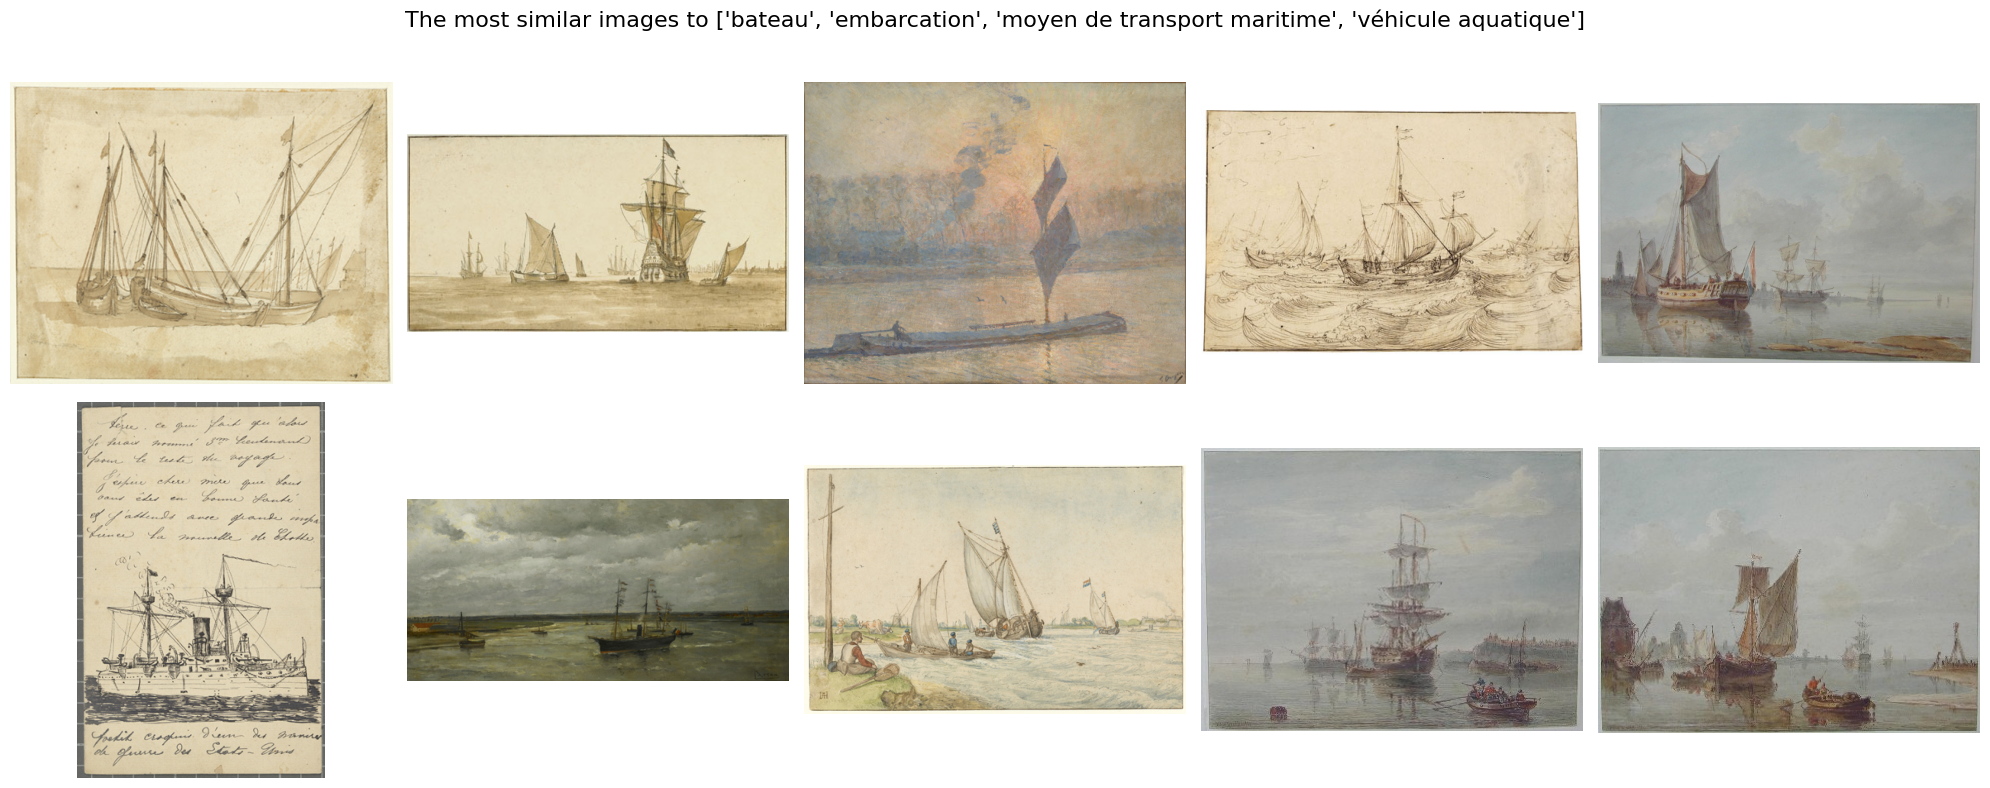

In [24]:
# Get the 10 most similar images to the selected keyword
index = 6
key = keys[index]
selected_keyword = keywords[key]
selected_keyword_embedding = keywords_embeddings[index]

# Compute the cosine similarity between the selected keyword embedding and all the other embeddings
cosine_similarities = cosine_similarity(selected_keyword_embedding.reshape(1, -1), images_embeddings)

# Get the 10 most similar images
ordered_indices = np.argsort(cosine_similarities)[0][::-1]
most_similar_images = [index_to_recordID[i] for i in ordered_indices[:10]]

# Plot the most similar images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i, recordID in enumerate(most_similar_images):
    image_path = None
    for __recordID, __image_path in DATA:
        if __recordID == recordID:
            image_path = __image_path
            break
    image = Image.open(getImagePath(image_path))
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")

plt.suptitle(f"The most similar images to {selected_keyword}", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
term_to_index = {}
for i, key in enumerate(keys):
    term_to_index[key] = i

with open(path_keywords_term_to_index, "w") as f:
    json.dump(term_to_index, f)

term_to_index

{'amour': 0,
 'animal': 1,
 'arbre': 2,
 'arme': 3,
 'assiette': 4,
 'avion': 5,
 'bateau': 6,
 'bijou': 7,
 'boisson': 8,
 'bol': 9,
 'bâtiment': 10,
 'carte': 11,
 'ciel': 12,
 'colère': 13,
 'corps': 14,
 'couleur': 15,
 'document': 16,
 'dégoût': 17,
 'enfant': 18,
 'espace': 19,
 'famille': 20,
 'femme': 21,
 'fleur': 22,
 'forme': 23,
 'fruit': 24,
 'globe': 25,
 'groupe': 26,
 'guerre': 27,
 'haine': 28,
 'homme': 29,
 'horloge': 30,
 'insecte': 31,
 'instrument_musique': 32,
 'joie': 33,
 'lampe': 34,
 'lettre': 35,
 'livre': 36,
 'lumière': 37,
 'lune': 38,
 'légume': 39,
 'main': 40,
 'maison': 41,
 'meuble': 42,
 'miroir': 43,
 'montagne': 44,
 'mouvement': 45,
 'nourriture': 46,
 'nuage': 47,
 'océan': 48,
 'oiseau': 49,
 'ombre': 50,
 'outil': 51,
 'pain': 52,
 'paix': 53,
 'peur': 54,
 'pied': 55,
 'poisson': 56,
 'pont': 57,
 'reptile': 58,
 'rivière': 59,
 'rue': 60,
 'soleil': 61,
 'surprise': 62,
 'symbole': 63,
 'tasse': 64,
 'temps': 65,
 'texture': 66,
 'tissu': 67